In [1]:
# Imports
import json
import numpy as np
import pandas as pd
import pickle as pkl
import datetime as dt
import random
import sys
import os.path
from os import path
import torch
from torch.utils.data import DataLoader
from pathlib import Path
#plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab
from pylab import cm
from matplotlib import colors as mcol

# For the regression.
import scipy
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF, ConstantKernel as C
from sklearn.metrics import r2_score
from netCDF4 import Dataset as NetCDFFile

sys.path.insert(1, '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/')
import metrics
import signatures
from xarray.core.dataarray import DataArray

In [2]:
# To make plots dynamic
#%matplotlib notebook
#%matplotlib notebook

In [3]:
MAIN_DIR = "/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/"
ig_dir = MAIN_DIR+'igs/'
IG_DIR = Path(ig_dir)
# Path to the main data folder
data_dir = MAIN_DIR+'data/'
DATA_DIR = Path(data_dir)
# Path to the main CAMELS folder
CAMELS_DIR = MAIN_DIR
# Path to the main directory of this repository
BASE_CODE_DIR = MAIN_DIR + 'papercode/'
# Needed if no precomputed results are used. Path to a single run
BASE_RUN_DIR = MAIN_DIR+'runs/run_0806_123405_seed83357'
# Convert to PosixPaths
CAMELS_DIR = Path(CAMELS_DIR)
BASE_RUN_DIR = Path(BASE_RUN_DIR)

In [4]:
# Start and end date of the validation period
VAL_START = pd.to_datetime('01101994', format='%d%m%Y')
VAL_END = pd.to_datetime('30092003', format='%d%m%Y')
date_range = pd.date_range(start=VAL_START, end=VAL_END)
n_dates = date_range.shape[0]

In [5]:
sys.path.append(MAIN_DIR)
sys.path.append(BASE_CODE_DIR)
from main_nwmlstm import Model
from papercode.utils import get_basin_list
from papercode.datautils import load_attributes

In [6]:
# Use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(DEVICE)

cpu


In [7]:
# get list of modeled basins
basins = get_basin_list()
basins_int=[]
for b in basins:
    basins_int.append(int(b))
nbasins=len(basins)

In [8]:
# load run config
with open(BASE_RUN_DIR / "cfg.json", "r") as fp:
    cfg = json.load(fp)
# load means/stds from training period
df_att = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"), 
                             basins=basins,
                             keep_features=cfg["camels_attr"],
                             drop_lat_lon=False)

In [9]:
# Initialize new model
print('initializing model ...')
model = Model(input_size_dyn=51,
              input_size_stat=0,
              hidden_size=cfg["hidden_size"],
              dropout=cfg["dropout"]).to(DEVICE)
print('finished initializing model')

# load pre-trained weights
print('loading model ...')
weight_file = BASE_RUN_DIR / "model_epoch30.pt"
model.load_state_dict(torch.load(weight_file, map_location=DEVICE))
print('finished loading model')

initializing model ...
finished initializing model
loading model ...
finished loading model


In [10]:
# load scaler
print('loading scaler ...')
with open(CAMELS_DIR / "hdf_files/scaler_nwm_v2.p", 'rb') as f:
    scaler = pkl.load(f)
scaler["camels_attr_mean"] = df_att.mean()
scaler["camels_attr_std"] = df_att.std()
print('finished loading scaler')

loading scaler ...
finished loading scaler


In [11]:
# get additional static inputs
file_name = Path(MAIN_DIR) / 'data' / 'dynamic_features_nwm_v2.p'
with file_name.open("rb") as fp:
    additional_features = pkl.load(fp)
additional_features_list = list(additional_features[basins[0]].columns.values)
print(additional_features_list)

['p_mean_dyn', 'pet_mean_dyn', 'aridity_dyn', 't_mean_dyn', 'frac_snow_dyn', 'high_prec_freq_dyn', 'high_prec_dur_dyn', 'low_prec_freq_dyn', 'low_prec_dur_dyn', 'PET(mm/d)', 'streamflow', 'q_lateral', 'velocity', 'qSfcLatRunoff', 'qBucket', 'qBtmVertRunoff', 'ACCET', 'FIRA', 'FSA', 'FSNO', 'HFX', 'LH', 'SNEQV', 'SNOWH', 'SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4', 'SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4', 'TRAD', 'UGDRNOFF', 'mean_sfcheadsubrt', 'mean_zwattablrt', 'max_sfcheadsubrt', 'max_zwattablrt']


In [12]:
camels_attr = ['elev_mean', 'slope_mean', 'area_gages2', 'frac_forest',
             'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff',
             'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
             'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
             'carbonate_rocks_frac', 'geol_permeability']
dynamic_inputs_orig = ['PRCP(mm/day)','Tmax', 'Tmim','SRAD', 'Vp']

In [13]:
pd_date_range = pd.date_range(VAL_START, VAL_END)
n_times = pd_date_range.shape[0]

In [14]:
# the features of the model are some attributes, meteorlogical inputes and NWM CHRT+LDAS
nwm_features = additional_features_list[10:]
model_features= dynamic_inputs_orig + nwm_features + camels_attr
feature_source = ['atm'] * len(dynamic_inputs_orig) + \
                 ['nwm'] * len(additional_features_list[10:]) + \
                 ['cam'] * len(camels_attr)
plt_labels_all = [feature_source[i]+'_'+model_features[i] for i in range(len(model_features))]

In [15]:
model_features[0:33]

['PRCP(mm/day)',
 'Tmax',
 'Tmim',
 'SRAD',
 'Vp',
 'streamflow',
 'q_lateral',
 'velocity',
 'qSfcLatRunoff',
 'qBucket',
 'qBtmVertRunoff',
 'ACCET',
 'FIRA',
 'FSA',
 'FSNO',
 'HFX',
 'LH',
 'SNEQV',
 'SNOWH',
 'SOIL_M1',
 'SOIL_M2',
 'SOIL_M3',
 'SOIL_M4',
 'SOIL_W1',
 'SOIL_W2',
 'SOIL_W3',
 'SOIL_W4',
 'TRAD',
 'UGDRNOFF',
 'mean_sfcheadsubrt',
 'mean_zwattablrt',
 'max_sfcheadsubrt',
 'max_zwattablrt']

In [16]:
# The integrated gradients are in a np.arrat with dimensions
# 1: prediction dates
# 2: lagging time before prediction
# 3: model features

In [17]:
calculate_sums = False
dump_sums = False
if calculate_sums:
    random_basins = basins
    random.shuffle(random_basins)
    numb = 0
    for b in random_basins:

        # Check that the IGs have been calculated.
        fname = MAIN_DIR+'igs/'+b+'_precip.p'
        if not path.exists(fname):
            continue

        # Count the number of basins processed
        numb+=1

        # Open the integrated gradients data
        with open(fname,'rb') as f:
            basin_igs = pkl.load(f)

        # Calculate the sums
        # Sum across time
        ig_sum_time = np.sum(np.absolute(basin_igs), axis=0)
        # Sum across lookback
        ig_sum_lookback = np.sum(np.absolute(basin_igs), axis=1)
        # Sum across lookback, then time
        ig_sum_lookback_time = np.sum(np.sum(np.absolute(basin_igs), axis=1), axis=0)
        # Sum across lookback, then features
        ig_sum_lookback_feature = np.sum(np.sum(np.absolute(basin_igs), axis=1), axis=1)

        if numb == 1:
            all_ig_sum_lookback_time = ig_sum_lookback_time
            all_ig_sum_lookback_feature = ig_sum_lookback_feature
        else:
            all_ig_sum_lookback_time = np.append(all_ig_sum_lookback_time, ig_sum_lookback_time, axis=0)
            all_ig_sum_lookback_feature = np.append(all_ig_sum_lookback_feature, ig_sum_lookback_feature, axis=0)

    # Reshape numpy to have all the columns line up
    all_ig_sum_lookback_time_reshaped = all_ig_sum_lookback_time.reshape(numb, basin_igs.shape[2])
    all_ig_sum_lookback_feature_reshaped = all_ig_sum_lookback_feature.reshape(numb, basin_igs.shape[0])
    
    if dump_sums:
        # Save values to pickle file
        with open(MAIN_DIR+'igs/sum_all_ig_lookback_time_ASF.p','wb') as f:
            pkl.dump(all_ig_sum_lookback_time_reshaped, f)
        with open(MAIN_DIR+'igs/sum_all_ig_lookback_feature_ASF.p','wb') as f:
            pkl.dump(all_ig_sum_lookback_feature_reshaped, f)
else:
    # Open pickle file with values
    with open(MAIN_DIR+'igs/sum_all_ig_lookback_time_ASF.p','rb') as f:
        all_ig_sum_lookback_time_reshaped = pkl.load(f)
    # Open pickle file with values
    with open(MAIN_DIR+'igs/sum_all_ig_lookback_feature_ASF.p','rb') as f:
        all_ig_sum_lookback_feature_reshaped = pkl.load(f)

In [18]:
print(all_ig_sum_lookback_time_reshaped.shape)
print(all_ig_sum_lookback_feature_reshaped.shape)

(531, 51)
(531, 3287)


In [19]:
# Now get the sums
sum_all_ig_pred_t = np.sum(np.absolute(all_ig_sum_lookback_time_reshaped), axis=0)

In [20]:
# Set up a sorted data frame
n_features = 33
d={'ig_pred_t':sum_all_ig_pred_t,#[0:n_features], 
   'model_features':model_features,#[0:n_features], 
   'feature_source':feature_source}#[0:n_features]}
df = pd.DataFrame(d)
df.set_index('model_features')
df = df.sort_values('ig_pred_t')

In [21]:
nwm_ldas =  ['ACCET', 'FSNO', 'SNOWH', 'TRAD', 'UGDRNOFF', 'FSA', 'FIRA','HFX','LH','SNEQV',
               'SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4', 'SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4']
nwm_rt = ['mean_sfcheadsubrt', 'mean_zwattablrt', 'max_sfcheadsubrt', 'max_zwattablrt']

In [22]:
for i in range(df.shape[0]):
    if df.iloc[i].feature_source == 'nwm':
        if df.iloc[i].model_features in nwm_ldas:
            df.iloc[i,2] = 'nwm_ldas'
        elif df.iloc[i].model_features in nwm_rt:
            df.iloc[i,2] = 'nwm_rt'
        else:
            df.iloc[i,2] = 'nwm_chrt'
print(df)

        ig_pred_t        model_features feature_source
32   45749.464101        max_zwattablrt         nwm_rt
29   74571.952731     mean_sfcheadsubrt         nwm_rt
33   77848.453119             elev_mean            cam
37   80918.841387               lai_max            cam
6    83827.240935             q_lateral       nwm_chrt
39   83980.153862               gvf_max            cam
38   84658.919885              lai_diff            cam
43   85459.120871         soil_porosity            cam
44   89789.743470     soil_conductivity            cam
40   92759.571198              gvf_diff            cam
34   93366.162946            slope_mean            cam
8    93631.370357         qSfcLatRunoff       nwm_chrt
41   94638.397572  soil_depth_pelletier            cam
46   95030.903032             sand_frac            cam
42  102959.772332    soil_depth_statsgo            cam
11  108064.648312                 ACCET       nwm_ldas
35  110556.742626           area_gages2            cam
45  118841

In [23]:
# for imf, mf in enumerate(df.model_features):
#     if mf == 'qSfcLatRunoff':
#         df.iloc[imf,1] = 'qLateral'
#     if mf == 'qBtmVertRunoff':
#         df.iloc[imf,1] = 'qBottom'
#     if mf == 'PRCP(mm/day)':
#         df.iloc[imf,1] = 'PRCP'
#     if mf == 'max_':
#         df.iloc[imf,1] = 'max ponding'
#     if mf == 'mean_':
#         df.iloc[imf,1] = 'mean ponding'
#     if mf == 'max_':
#         df.iloc[imf,1] = 'max gw depth'
#     if mf == 'mean_':
#         df.iloc[imf,1] = 'mean gw depth'

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <BarContainer object of 51 artists> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


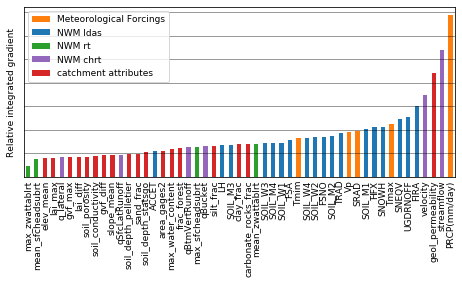

In [24]:
# get the colors based on the feature source
# grab colors for manual plotting
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colorz=[]
for cfs in df.feature_source:
    if cfs == 'atm':
        colorz.append(colors[1])
    if cfs == 'nwm_ldas':
        colorz.append(colors[0])
    if cfs == 'nwm_rt':
        colorz.append(colors[2])
    if cfs == 'nwm_chrt':
        colorz.append(colors[4])
    if cfs == 'cam':
        colorz.append(colors[3])

# Make a good looking plot
mpl.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(figsize=(6.5,4.02))
df.plot(kind='bar', x='model_features', y='ig_pred_t', ax=ax, \
        color=colorz, label='_nolegend_')
plt.ylabel('Relative integrated gradient')
plt.xlabel('')
ax.grid(b=None, which='major', axis='y')
ax.set_yticklabels([])
ax.tick_params(direction='in', length=0, width=0, colors='k',
              grid_color='k', grid_alpha=0.5)

labelz = ['Meteorological Forcings', 'NWM ldas','NWM rt', 'NWM chrt','catchment attributes']
colorz = [colors[1],colors[0],colors[2], colors[4],colors[3]]
for ilab, icol in zip(labelz,colorz):
    #Plot invisible bar graph but have the legends specified
    ax.bar(model_features, sum_all_ig_pred_t,width=0,color=icol,label=ilab)
ax.legend(loc='upper left')
#plt.title('Input attributions for LSTM+NWM post processor predictions')
plt.tight_layout()
#plt.savefig(MAIN_DIR+'igs_plots/igs_bar_all.png')
plt.show()
plt.close()

In [25]:
df=df.reset_index()

In [26]:
df = df.set_index('model_features')
df_slim = df.copy(deep=True)
df_slim = df_slim.drop(['mean_sfcheadsubrt','max_sfcheadsubrt','mean_zwattablrt','max_zwattablrt'], axis=0)
df_slim = df_slim.drop(['SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4'], axis=0)
df_slim = df_slim.drop(['SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4'], axis=0)

temp_mean=df.loc[('max_sfcheadsubrt','mean_sfcheadsubrt'),'ig_pred_t'].mean()
sfc = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_rt'}, index=['sfcheadsubrt'])
df_slim = pd.concat([df_slim, sfc])

temp_mean=df.loc[('max_zwattablrt','mean_zwattablrt'),'ig_pred_t'].mean()
zwa = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_rt'}, index=['zwattablrt'])
df_slim = pd.concat([df_slim, zwa])

temp_mean=df.loc[('SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4'),'ig_pred_t'].mean()
sm = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_ldas'}, index=['SOIL_M'])
df_slim = pd.concat([df_slim, sm])

temp_mean=df.loc[('SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4'),'ig_pred_t'].mean()
sw = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_ldas'}, index=['SOIL_W'])
df_slim = pd.concat([df_slim, sw])

df=df.reset_index()
df_slim.index.names = ['model_features']
df_slim = df_slim.sort_values('ig_pred_t')
df_slim=df_slim.reset_index()


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'so

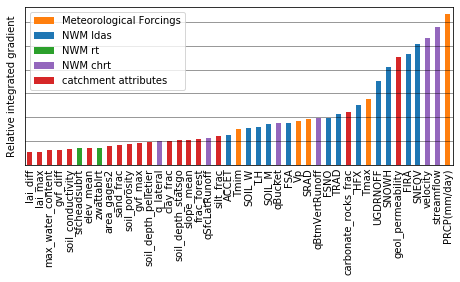

In [33]:
# get the colors based on the feature source
# grab colors for manual plotting
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colorz=[]
for cfs in df_slim.feature_source:
    if cfs == 'atm':
        colorz.append(colors[1])
    if cfs == 'nwm_ldas':
        colorz.append(colors[0])
    if cfs == 'nwm_rt':
        colorz.append(colors[2])
    if cfs == 'nwm_chrt':
        colorz.append(colors[4])
    if cfs == 'cam':
        colorz.append(colors[3])

# Make a good looking plot
mpl.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(6.5,4.02))
df_slim.plot(kind='bar', x='model_features', y='ig_pred_t', ax=ax, \
        color=colorz, label='_nolegend_')
plt.ylabel('Relative integrated gradient')
plt.xlabel('')
ax.grid(b=None, which='major', axis='y')
ax.set_yticklabels([])
ax.tick_params(direction='in', length=0, width=0, colors='k',
              grid_color='k', grid_alpha=0.5)

labelz = ['Meteorological Forcings', 'NWM ldas','NWM rt', 'NWM chrt','catchment attributes']
colorz = [colors[1],colors[0],colors[2], colors[4],colors[3]]
for ilab, icol in zip(labelz,colorz):
    #Plot invisible bar graph but have the legends specified
    ax.bar(model_features, sum_all_ig_pred_t, width=0,color=icol,label=ilab)
ax.legend(loc='upper left')
#plt.title('Input attributions for LSTM+NWM post processor predictions')
plt.tight_layout()
#plt.savefig(MAIN_DIR+'igs_plots/igs_bar_all.png')
plt.show()
fig.savefig('fig9.png', dpi=1200)
plt.close()

In [28]:
df_slim

,model_features,feature_source,ig_pred_t,index
0,elev_mean,cam,77848.453119,33.0
1,lai_max,cam,80918.841387,37.0
2,q_lateral,nwm_chrt,83827.240935,6.0
3,gvf_max,cam,83980.153862,39.0
4,lai_diff,cam,84658.919885,38.0
5,soil_porosity,cam,85459.120871,43.0
6,soil_conductivity,cam,89789.743470,44.0
7,zwattablrt,nwm_rt,92663.738587,NaN
8,gvf_diff,cam,92759.571198,40.0
9,slope_mean,cam,93366.162946,34.0


# Regional analysis

In [29]:
openthis = '/home/NearingLab/data/camels_all_coding_workshop.csv'
attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit
regions = attributes['basin_hydro_unit'].unique()

In [30]:
if False:
    for region in regions:

        regional_basins = list(attributes.loc[attributes['basin_hydro_unit'] == region, 'basin_id_str'])

        numb = 0
        for b in regional_basins:

            # Check that the IGs have been calculated.
            fname = MAIN_DIR+'igs/'+b+'_precip.p'
            if not path.exists(fname):
                continue

            # Count the number of basins processed
            numb+=1

            # Open the integrated gradients data
            with open(fname,'rb') as f:
                basin_igs = pkl.load(f)

            # Calculate the sums
            # Sum across time
            ig_sum_time = np.sum(np.absolute(basin_igs), axis=0)
            # Sum across lookback
            ig_sum_lookback = np.sum(np.absolute(basin_igs), axis=1)
            # Sum across lookback, then time
            ig_sum_lookback_time = np.sum(np.sum(np.absolute(basin_igs), axis=1), axis=0)
            # Sum across lookback, then features
            ig_sum_lookback_feature = np.sum(np.sum(np.absolute(basin_igs), axis=1), axis=1)

            if numb == 1:
                all_ig_sum_lookback_time = ig_sum_lookback_time
                all_ig_sum_lookback_feature = ig_sum_lookback_feature
            else:
                all_ig_sum_lookback_time = np.append(all_ig_sum_lookback_time, ig_sum_lookback_time, axis=0)
                all_ig_sum_lookback_feature = np.append(all_ig_sum_lookback_feature, ig_sum_lookback_feature, axis=0)

        # Reshape numpy to have all the columns line up
        all_ig_sum_lookback_time_reshaped = all_ig_sum_lookback_time.reshape(numb, basin_igs.shape[2])
        all_ig_sum_lookback_feature_reshaped = all_ig_sum_lookback_feature.reshape(numb, basin_igs.shape[0])

        # Save values to pickle file
        with open(MAIN_DIR+'igs/ASF_sums/sum_all_ig_lookback_time_{}.p'.format(region),'wb') as f:
            pkl.dump(all_ig_sum_lookback_time_reshaped, f)
        with open(MAIN_DIR+'igs/ASF_sums/sum_all_ig_lookback_feature_{}.p'.format(region),'wb') as f:
            pkl.dump(all_ig_sum_lookback_feature_reshaped, f)

In [31]:
nwm_ldas =  ['ACCET', 'FSNO', 'SNOWH', 'TRAD', 'UGDRNOFF', 'FSA', 'FIRA','HFX','LH','SNEQV',
               'SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4', 'SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4']
nwm_rt = ['mean_sfcheadsubrt', 'mean_zwattablrt', 'max_sfcheadsubrt', 'max_zwattablrt']

REGION 01
n =  22


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and

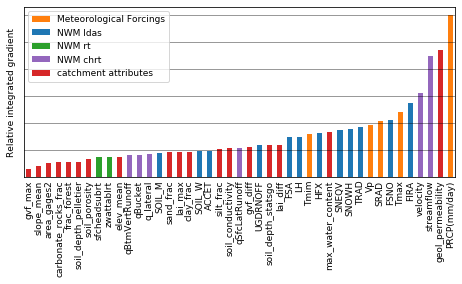

REGION 02
n =  69


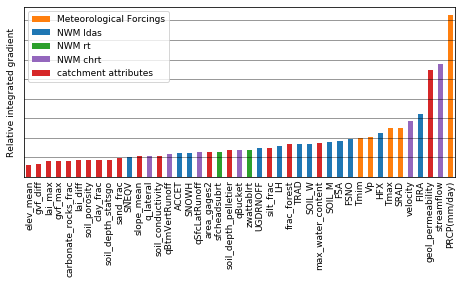

REGION 03
n =  79


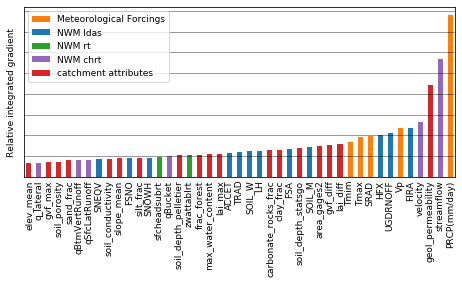

REGION 05
n =  35


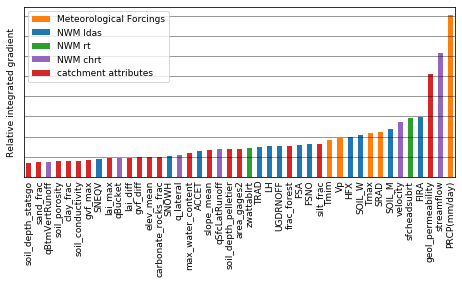

REGION 06
n =  16


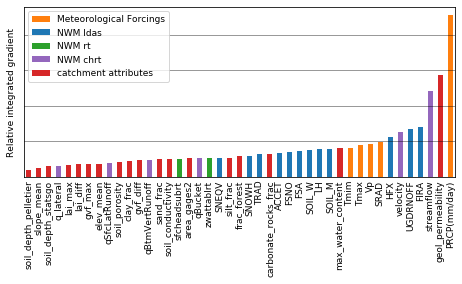

REGION 04
n =  30


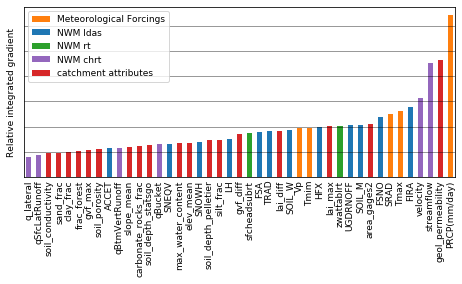

REGION 09
n =  2


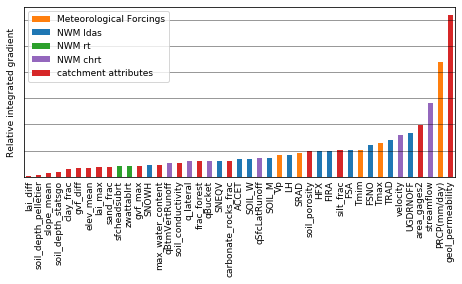

REGION 07
n =  29


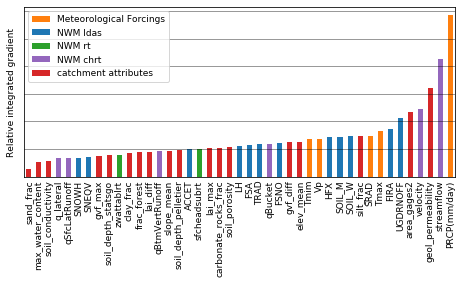

REGION 10
n =  49


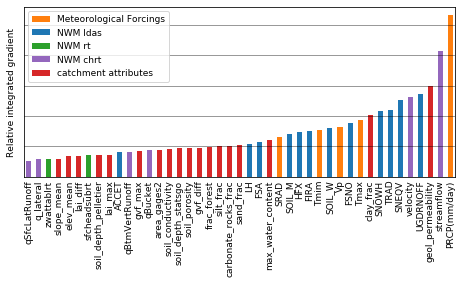

REGION 11
n =  22


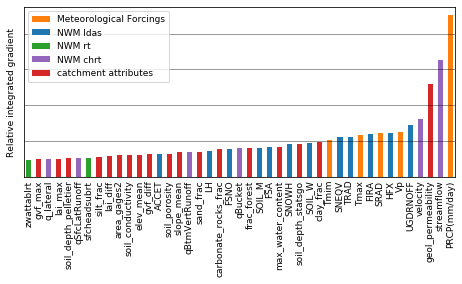

REGION 08
n =  7


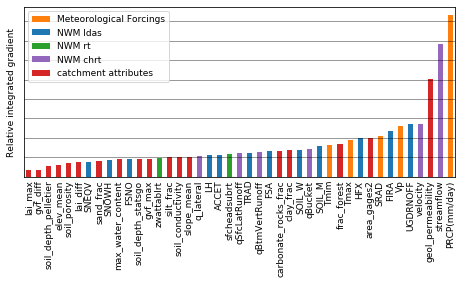

REGION 12
n =  32


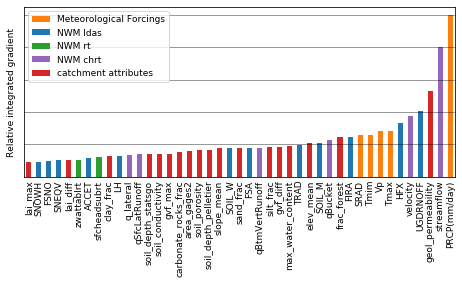

REGION 13
n =  7


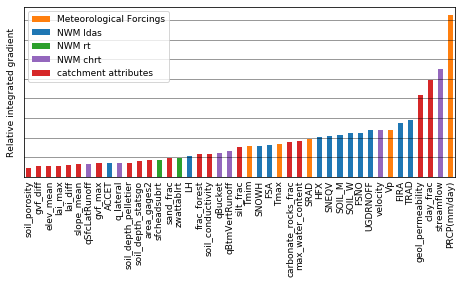

REGION 14
n =  15


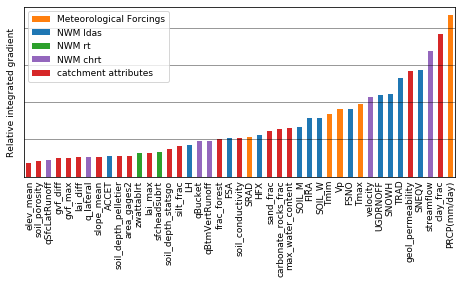

REGION 15
n =  14


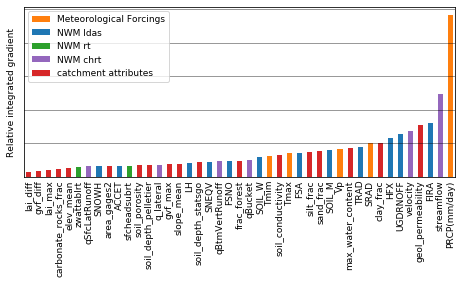

REGION 16
n =  5


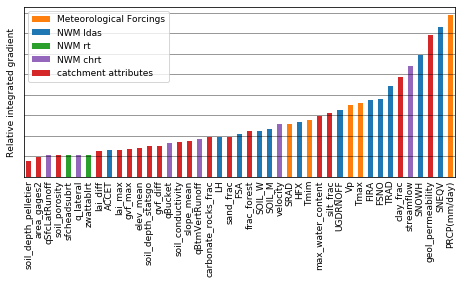

REGION 18
n =  26


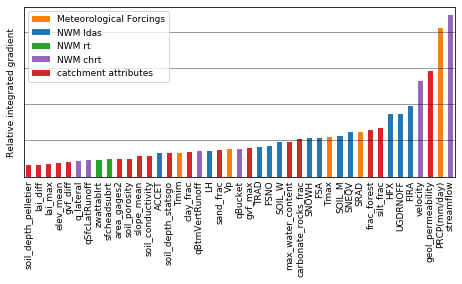

REGION 17
n =  72


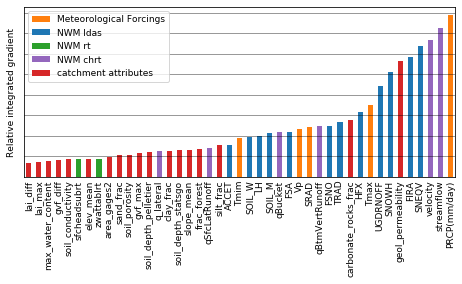

In [32]:

for region in regions:

    print('REGION', region)
    
    # Open pickle file with values
    with open(MAIN_DIR+'igs/ASF_sums/sum_all_ig_lookback_time_{}.p'.format(region),'rb') as f:
        all_ig_sum_lookback_time_reshaped = pkl.load(f)
    # Open pickle file with values
    with open(MAIN_DIR+'igs/ASF_sums/sum_all_ig_lookback_feature_{}.p'.format(region),'rb') as f:
        all_ig_sum_lookback_feature_reshaped = pkl.load(f)    
    
    print('n = ',all_ig_sum_lookback_time_reshaped.shape[0])
    
    # Now get the sums
    sum_all_ig_pred_t = np.sum(np.absolute(all_ig_sum_lookback_time_reshaped), axis=0)
    # Set up a sorted data frame
    n_features = 33
    d={'ig_pred_t':sum_all_ig_pred_t,#[0:n_features], 
       'model_features':model_features,#[0:n_features], 
       'feature_source':feature_source}#[0:n_features]}
    df = pd.DataFrame(d)
    df.set_index('model_features')
    df = df.sort_values('ig_pred_t')
    for i in range(df.shape[0]):
        if df.iloc[i].feature_source == 'nwm':
            if df.iloc[i].model_features in nwm_ldas:
                df.iloc[i,2] = 'nwm_ldas'
            elif df.iloc[i].model_features in nwm_rt:
                df.iloc[i,2] = 'nwm_rt'
            else:
                df.iloc[i,2] = 'nwm_chrt'
    df=df.reset_index()
    df = df.set_index('model_features')
    df_slim = df.copy(deep=True)
    df_slim = df_slim.drop(['mean_sfcheadsubrt','max_sfcheadsubrt','mean_zwattablrt','max_zwattablrt'], axis=0)
    df_slim = df_slim.drop(['SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4'], axis=0)
    df_slim = df_slim.drop(['SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4'], axis=0)

    temp_mean=df.loc[('max_sfcheadsubrt','mean_sfcheadsubrt'),'ig_pred_t'].mean()
    sfc = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_rt'}, index=['sfcheadsubrt'])
    df_slim = pd.concat([df_slim, sfc])

    temp_mean=df.loc[('max_zwattablrt','mean_zwattablrt'),'ig_pred_t'].mean()
    zwa = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_rt'}, index=['zwattablrt'])
    df_slim = pd.concat([df_slim, zwa])

    temp_mean=df.loc[('SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4'),'ig_pred_t'].mean()
    sm = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_ldas'}, index=['SOIL_M'])
    df_slim = pd.concat([df_slim, sm])

    temp_mean=df.loc[('SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4'),'ig_pred_t'].mean()
    sw = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_ldas'}, index=['SOIL_W'])
    df_slim = pd.concat([df_slim, sw])

    df=df.reset_index()
    df_slim.index.names = ['model_features']
    df_slim = df_slim.sort_values('ig_pred_t')
    df_slim=df_slim.reset_index()
    # grab colors for manual plotting
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    colorz=[]
    for cfs in df_slim.feature_source:
        if cfs == 'atm':
            colorz.append(colors[1])
        if cfs == 'nwm_ldas':
            colorz.append(colors[0])
        if cfs == 'nwm_rt':
            colorz.append(colors[2])
        if cfs == 'nwm_chrt':
            colorz.append(colors[4])
        if cfs == 'cam':
            colorz.append(colors[3])

    # Make a good looking plot
    mpl.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    df_slim.plot(kind='bar', x='model_features', y='ig_pred_t', ax=ax, \
            color=colorz, label='_nolegend_')
    plt.ylabel('Relative integrated gradient')
    plt.xlabel('')
    ax.grid(b=None, which='major', axis='y')
    ax.set_yticklabels([])
    ax.tick_params(direction='in', length=0, width=0, colors='k',
                  grid_color='k', grid_alpha=0.5)

    labelz = ['Meteorological Forcings', 'NWM ldas','NWM rt', 'NWM chrt','catchment attributes']
    colorz = [colors[1],colors[0],colors[2], colors[4],colors[3]]
    for ilab, icol in zip(labelz,colorz):
        #Plot invisible bar graph but have the legends specified
        ax.bar(model_features, sum_all_ig_pred_t, width=0,color=icol,label=ilab)
    ax.legend(loc='upper left')
    #plt.title('Input attributions for LSTM+NWM post processor predictions')
    plt.tight_layout()
    #plt.savefig(MAIN_DIR+'igs_plots/igs_bar_all.png')
    plt.show()
    plt.close()